In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import json

from sklearn.metrics import adjusted_rand_score
from more_itertools import flatten
from scipy.special import gammaln, digamma
from scipy.stats import gamma

### Function for data extraction

In [8]:
def data_and_param_extract(idx, N_runs):
    ## LOAD RELEVANT DATA
    base_path = "analyses/simulation_studies/simulation_output/simulation_study_4/"

    output_dict = dict()

    ## alpha
    alpha_list = []
    for j in range(N_runs):
        file_path = base_path + f"alpha/alpha_store_{idx}_{j}.pkl"
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
        f.close()
        alpha_list.append(data)

    alpha_list_inf = []
    for j in range(N_runs):
        file_path = base_path + f"alpha/alpha_store_inf_{idx}_{j}.pkl"
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
        f.close()
        alpha_list_inf.append(data)

    ## beta
    beta_list = []
    for j in range(N_runs):
        file_path = base_path + f"beta/beta_store_{idx}_{j}.pkl"
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
        f.close()
        beta_list.append(data)    

    ## beta
    beta_list_inf = []
    for j in range(N_runs):
        file_path = base_path + f"beta/beta_store_inf_{idx}_{j}.pkl"
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
        f.close()
        beta_list_inf.append(data)

    ## tau
    tau_list = []
    for j in range(N_runs):
        file_path = base_path + f"tau/tau_store_{idx}_{j}.pkl"
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
        f.close()
        tau_list.append(data)

    tau_list_inf = []
    for j in range(N_runs):
        file_path = base_path + f"tau/tau_store_inf_{idx}_{j}.pkl"
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
        f.close()
        tau_list_inf.append(data)

    ## group changes
    group_changes_list = []
    for j in range(N_runs):
        file_path = base_path + f"group_changes_list/group_changes_list_{idx}_{j}.pkl"
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
        f.close()
        group_changes_list.append(data)

    ## group changes inf
    group_changes_list_inf = []
    for j in range(N_runs):
        file_path = base_path + f"group_changes_list/group_changes_list_inf_{idx}_{j}.pkl"
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
        f.close()
        group_changes_list_inf.append(data)

    
    ## group memberships
    group_memberships_list = []
    for j in range(N_runs):
        file_path = base_path + f"group_memberships/group_memberships_{idx}_{j}.pkl"
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
        f.close()
        group_memberships_list.append(data)

    ## group memberships inf
    group_memberships_list_inf = []
    for j in range(N_runs):
        file_path = base_path + f"group_memberships/group_memberships_inf_{idx}_{j}.pkl"
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
        f.close()
        group_memberships_list_inf.append(data)

    output_dict['alpha'] = alpha_list
    output_dict['beta'] = beta_list
    output_dict['tau'] = tau_list
    output_dict['alpha_inf'] = alpha_list_inf
    output_dict['beta_inf'] = beta_list_inf
    output_dict['tau_inf'] = tau_list_inf
    output_dict['group_changes'] = group_changes_list
    output_dict['group_memberships'] = group_memberships_list
    output_dict['group_changes_inf'] = group_changes_list_inf
    output_dict['group_memberships_inf'] = group_memberships_list_inf

    ## EXTRACT THE RELEVANT SIMULATION PARAMETERS
    param_path = "analyses/simulation_studies/simulation_parameters/simulation_study_4"
    with open(param_path + '/sim_params_simulation_study_4.json', 'r') as file:
        sim_params = json.load(file)
        # sim_params_curr = sim_params[int(idx * 5)]

    output_dict['lam_matrix'] = np.array([[2.0, 1.0], [0.3, 8.0]])
    output_dict['num_nodes'] = 500
    output_dict['num_groups'] = 2
    output_dict['group_props'] = np.array([0.6, 0.4])
    output_dict['n_cavi'] = 3
    output_dict['int_length'] = 0.1
    output_dict['T_max'] = 5
    output_dict['delta'] = 0.1
    output_dict['connection_prob'] = float(sim_params[0])    

    ## CONSTRUCT TRUE GROUP LABELS
    group_sizes = (output_dict['group_props'] * output_dict['num_nodes']).astype('int')
    output_dict['group_sizes'] = group_sizes
    missing_nodes = output_dict['num_nodes'] - group_sizes.sum()
    if missing_nodes != 0:
        if np.sum(np.where(group_sizes == 0)) != 0:
            group_sizes[np.where(group_sizes == 0)] = missing_nodes
        else:
            group_sizes[-1] += missing_nodes
    init_groups = np.array(
                list(flatten([[i]*j for i,j in enumerate(group_sizes)]))
                )
    change_groups = init_groups.copy()
    prop_swap = 0.25
    mem_change_nodes = np.arange(int(group_sizes[0] * prop_swap))
    change_groups[mem_change_nodes] = (1 - change_groups[mem_change_nodes])

    output_dict['groups_in_regions'] = [init_groups, change_groups]

    return output_dict


### Define macros

In [4]:
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)

colours = [(208/255, 28/255, 139/255),
           (241/255, 182/255, 218/255),
           (184/255, 225/255, 134/255),
           (77/255, 172/255, 38/255)]

### Compute adjusted rand index


In [121]:
B1 = 10

df_ARI = pd.DataFrame(columns=['connection_prob', 'ARI_inf', 'ARI'], 
                      index=range(6))

for sim in range(6):
    data_dict = data_and_param_extract(sim, 50)
    df_ARI.loc[sim, ['connection_prob']] = (
        data_dict['connection_prob']
    )  
    group_memberships = data_dict['group_memberships']
    _ARI_list_time = []
    for run in range(50):
        _ARI_list_run = []
        group_memberships_curr = group_memberships[run]

        # Up to first change
        true_groups = data_dict['groups_in_regions'][0]
        for time_step in range(int(1 / 0.1) + 1 - B1, int(10 / 0.1) + 1 - B1):
            _pred_groups = group_memberships_curr[time_step,:]
            _ARI = adjusted_rand_score(true_groups, _pred_groups)
            _ARI_list_run.append(_ARI)
        
        # After change
        true_groups = data_dict['groups_in_regions'][1]
        for time_step in range(int(10 / 0.1) + 1 - B1, int(25 / 0.1) + 1 - B1):
            _pred_groups = group_memberships_curr[time_step,:]
            _ARI = adjusted_rand_score(true_groups, _pred_groups)
            _ARI_list_run.append(_ARI)

        _ARI_list_time.append([l for l in _ARI_list_run])
    df_ARI.loc[sim, 'ARI'] = _ARI_list_time

for sim in range(6):
    data_dict = data_and_param_extract(sim, 50)
    df_ARI.loc[sim, ['connection_prob']] = (
        data_dict['connection_prob']
    )  
    group_memberships = data_dict['group_memberships_inf']    
    _ARI_list_time = []
    for run in range(50):
        _ARI_list_run = []
        group_memberships_curr = group_memberships[run]

        # Up to first change
        true_groups = data_dict['groups_in_regions'][0]
        for time_step in range(int(1 / 0.1) + 1 - B1, int(10 / 0.1) + 1 - B1):
            _pred_groups = group_memberships_curr[time_step,:]
            _ARI = adjusted_rand_score(true_groups, _pred_groups)
            _ARI_list_run.append(_ARI)
        
        # After change
        true_groups = data_dict['groups_in_regions'][1]
        for time_step in range(int(10 / 0.1) + 1 - B1, int(25 / 0.1) + 1 - B1):
            _pred_groups = group_memberships_curr[time_step,:]
            _ARI = adjusted_rand_score(true_groups, _pred_groups)
            _ARI_list_run.append(_ARI)

        _ARI_list_time.append([l for l in _ARI_list_run])
    df_ARI.loc[sim, 'ARI_inf'] = _ARI_list_time

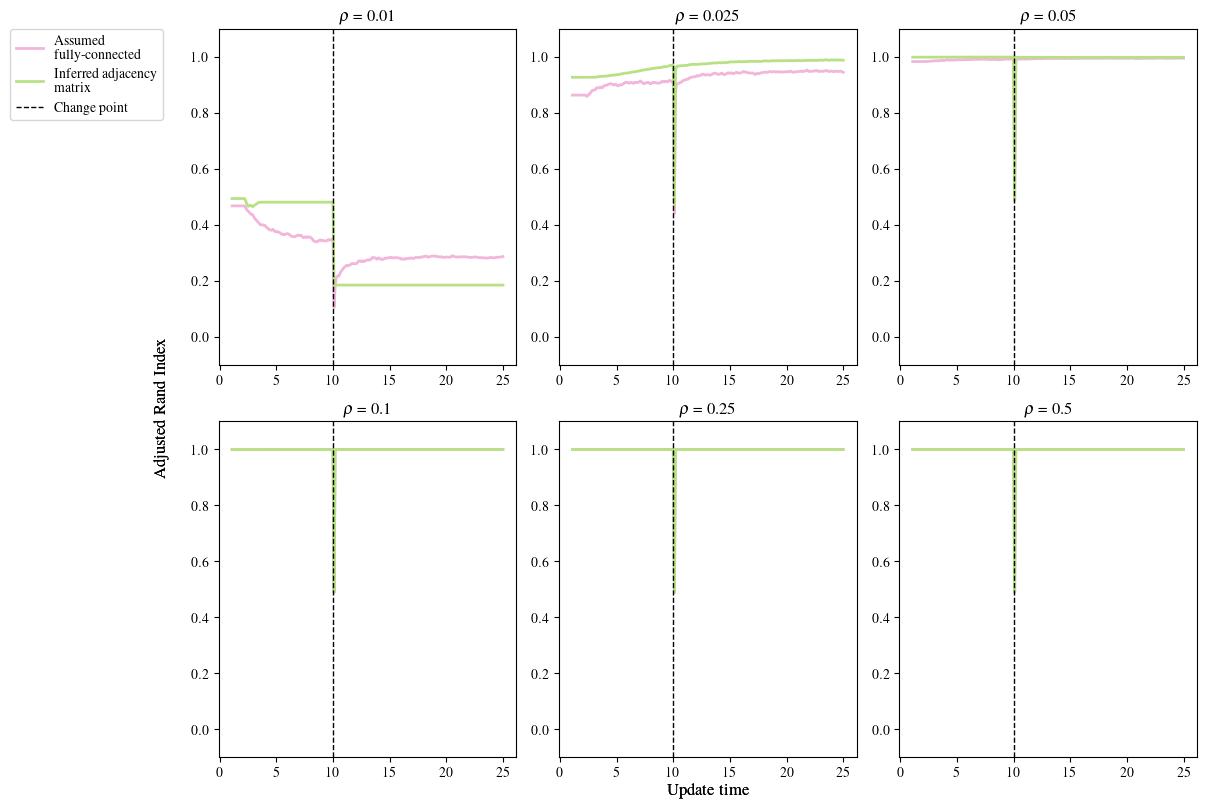

In [123]:
fig, axs = plt.subplots(2, 3, figsize=(12, 8))

legend_handles, legend_labels = [], []

row_counter = -1
connection_prob = [0.01, 0.025, 0.05, 0.1, 0.25, 0.5]
group_1_count = -1
for i in range(2):
    for j in range(3):
        group_1_count += 1
        index = df_ARI[
                    df_ARI['connection_prob'] == connection_prob[group_1_count]
                    ].index[0]
        ARI_data = df_ARI.loc[index, ['ARI', 'ARI_inf']]
        temp_array = np.array([np.array(entry) for entry in ARI_data['ARI']])
        temp_array_inf = np.array([np.array(entry) for entry in ARI_data['ARI_inf']])
        mean_ARI = temp_array.mean(axis=0)
        mean_ARI_inf = temp_array_inf.mean(axis=0)

        line1 = axs[i,j].plot(np.arange(1 + 0.1, 25 + 0.1, 0.1), mean_ARI, color = colours[1],
                        linewidth=2)
        axs[i,j].set_title(fr"$\rho$ = {connection_prob[group_1_count]}", fontsize=12)

        line2 = axs[i,j].plot(np.arange(1 + 0.1, 25 + 0.1, 0.1), mean_ARI_inf, color = colours[2],
                        linewidth=2)
        axs[i,j].set_title(fr"$\rho$ = {connection_prob[group_1_count]}", fontsize=12)
        line3 = axs[i,j].axvline(x=10, linestyle='--', linewidth=1, color='black')
        if (i == 0) & (j == 0):
            legend_handles.append(line1[0])
            legend_labels.append("Assumed\n fully-connected")
            legend_handles.append(line2[0])
            legend_labels.append("Inferred adjacency\n matrix")
            legend_handles.append(line3)
            legend_labels.append("Change point")
        axs[i,j].set_ylim([-0.1, 1.1])

    fig.text(0.58, 0, 'Update time', ha='center', fontsize=12)
    fig.text(0.125, 0.4, 'Adjusted Rand Index', ha='center', rotation='vertical', fontsize=12)

# Add legend to the top left subplot
axs[0, 0].legend(legend_handles, legend_labels, loc='upper left', bbox_to_anchor=(-0.7, 1.0), borderaxespad=0.0)

plt.tight_layout()

plt.savefig("analyses/simulation_studies/simulation_output/simulation_study_4/plots/ARI_time.pdf",
            bbox_inches='tight')

### Posterior rate

In [116]:
df_rates = pd.DataFrame(columns=['connection_prob', 'upper', 'lower', 'mean',
                                 'upper_inf', 'lower_inf', 'mean_inf'], index=range(6))

for sim in range(6):
    data_dict = data_and_param_extract(sim, 50)
    df_rates.loc[sim, ['connection_prob']] = (
        data_dict['connection_prob']
    )  
    alpha_list = data_dict['alpha']; beta_list = data_dict['beta']
    alpha_list_inf = data_dict['alpha_inf']; beta_list_inf = data_dict['beta_inf']
    mean_sim = []; upper_sim = []; lower_sim = []
    mean_sim_inf = []; upper_sim_inf = []; lower_sim_inf = []
    for run in range(50):
        alpha_run = alpha_list[run]; beta_run = beta_list[run]
        alpha_run_inf = alpha_list_inf[run]; beta_run_inf = beta_list_inf[run]
        gamma_rv = gamma(a = alpha_run, scale = 1 / beta_run)
        gamma_rv_inf = gamma(a = alpha_run_inf, scale = 1 / beta_run_inf)

        mean_sim.append(gamma_rv.mean())
        upper_sim.append(gamma_rv.ppf(0.975))
        lower_sim.append(gamma_rv.ppf(0.025))

        # Account for label differences between runs
        for it in range(len(mean_sim)):
            max_entry = (
                np.where(mean_sim[it][5,:,:] == mean_sim[it][5,:,:].max())
            )
            if (max_entry[0] == 1) & (max_entry[1] == 1):
                mean_sim_copy = mean_sim[it].copy()
                mean_sim_copy[:,1,1] = mean_sim[it][:,0,0]
                mean_sim_copy[:,0,0] = mean_sim[it][:,1,1]
                mean_sim_copy[:,1,0] = mean_sim[it][:,0,1]
                mean_sim_copy[:,0,1] = mean_sim[it][:,1,0]
                mean_sim[it] = mean_sim_copy.copy()

                upper_sim_copy = upper_sim[it].copy()
                upper_sim_copy[:,1,1] = upper_sim[it][:,0,0]
                upper_sim_copy[:,0,0] = upper_sim[it][:,1,1]
                upper_sim_copy[:,1,0] = upper_sim[it][:,0,1]
                upper_sim_copy[:,0,1] = upper_sim[it][:,1,0]
                upper_sim[it] = upper_sim_copy.copy()

                lower_sim_copy = lower_sim[it].copy()
                lower_sim_copy[:,1,1] = lower_sim[it][:,0,0]
                lower_sim_copy[:,0,0] = lower_sim[it][:,1,1]
                lower_sim_copy[:,1,0] = lower_sim[it][:,0,1]
                lower_sim_copy[:,0,1] = lower_sim[it][:,1,0]
                lower_sim[it] = lower_sim_copy.copy()

        mean_sim_inf.append(gamma_rv_inf.mean())
        upper_sim_inf.append(gamma_rv_inf.ppf(0.975))
        lower_sim_inf.append(gamma_rv_inf.ppf(0.025))

        # Account for label differences between runs
        for it in range(len(mean_sim_inf)):
            max_entry = (
                np.where(mean_sim_inf[it][5,:,:] == mean_sim_inf[it][5,:,:].max())
            )
            if (max_entry[0] == 1) & (max_entry[1] == 1):
                mean_sim_copy = mean_sim_inf[it].copy()
                mean_sim_copy[:,1,1] = mean_sim_inf[it][:,0,0]
                mean_sim_copy[:,0,0] = mean_sim_inf[it][:,1,1]
                mean_sim_copy[:,1,0] = mean_sim_inf[it][:,0,1]
                mean_sim_copy[:,0,1] = mean_sim_inf[it][:,1,0]
                mean_sim_inf[it] = mean_sim_copy.copy()

                upper_sim_copy = upper_sim_inf[it].copy()
                upper_sim_copy[:,1,1] = upper_sim_inf[it][:,0,0]
                upper_sim_copy[:,0,0] = upper_sim_inf[it][:,1,1]
                upper_sim_copy[:,1,0] = upper_sim_inf[it][:,0,1]
                upper_sim_copy[:,0,1] = upper_sim_inf[it][:,1,0]
                upper_sim_inf[it] = upper_sim_copy.copy()

                lower_sim_copy = lower_sim_inf[it].copy()
                lower_sim_copy[:,1,1] = lower_sim_inf[it][:,0,0]
                lower_sim_copy[:,0,0] = lower_sim_inf[it][:,1,1]
                lower_sim_copy[:,1,0] = lower_sim_inf[it][:,0,1]
                lower_sim_copy[:,0,1] = lower_sim_inf[it][:,1,0]
                lower_sim_inf[it] = lower_sim_copy.copy()

    mean_sim = np.stack(mean_sim).mean(axis=0)
    lower_sim = np.stack(lower_sim).mean(axis=0)
    upper_sim = np.stack(upper_sim).mean(axis=0)
    mean_sim_inf = np.stack(mean_sim_inf).mean(axis=0)
    lower_sim_inf = np.stack(lower_sim_inf).mean(axis=0)
    upper_sim_inf = np.stack(upper_sim_inf).mean(axis=0)

    df_rates.loc[sim, ['upper', 'lower', 'mean']] = (
        [upper_sim, lower_sim, mean_sim]
    )
    df_rates.loc[sim, ['upper_inf', 'lower_inf', 'mean_inf']] = (
        [upper_sim_inf, lower_sim_inf, mean_sim_inf]
    )


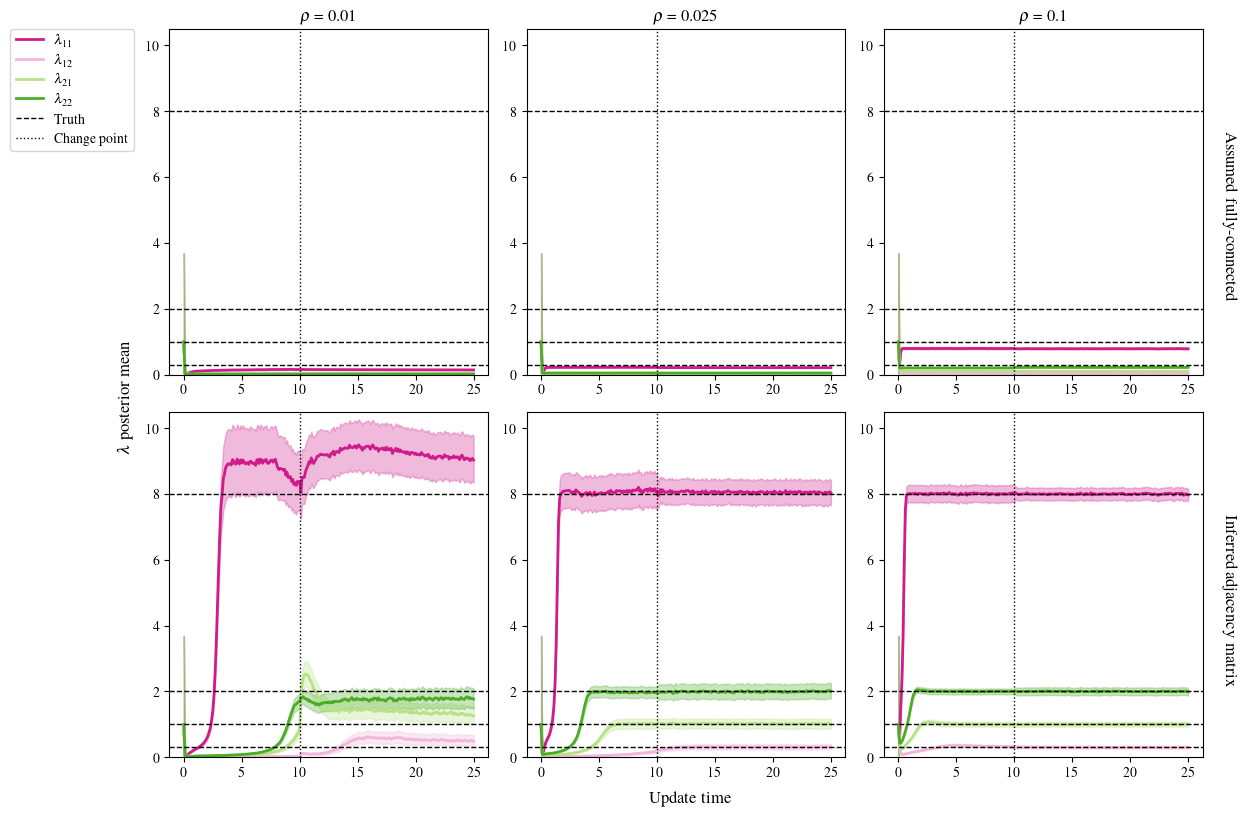

In [119]:
fig, axs = plt.subplots(2, 3, figsize=(12, 8))

row_counter = -1
connection_prob = [0.01, 0.025, 0.1]
legend_handles, legend_labels = [], []

for i, inf in enumerate([0, 1]):
    for j in range(3):
        index = df_rates[
                    (df_rates['connection_prob'] == connection_prob[j])
                    ].index[0]
        if inf == 0:
            mean = df_rates.loc[index, 'mean']
            upper = df_rates.loc[index, 'upper']
            lower = df_rates.loc[index, 'lower']
        else:
            mean = df_rates.loc[index, 'mean_inf']
            upper = df_rates.loc[index, 'upper_inf']
            lower = df_rates.loc[index, 'lower_inf']
            
        colour_idx = -1
        for k in range(2):
            for m in range(2):
                colour_idx += 1
                line = axs[i,j].plot(np.arange(0, 25 + 0.1, 0.1), mean[:,k,m],
                              color = colours[colour_idx], linewidth=2)
                axs[i,j].fill_between(np.arange(0, 25 + 0.1, 0.1), lower[:,k,m], upper[:,k,m],
                                      alpha=0.3, color = colours[colour_idx])
                if i == 0:
                    axs[i,j].set_title(fr"$\rho$ = {connection_prob[j]}", fontsize=12)
                # Append handles and labels for the legend
                if (i == 0) & (j == 0):
                    legend_handles.append(line[0])
                    legend_labels.append(r'$\lambda_{%d%d}$' % (k+1, m+1))
        line1 = axs[i,j].axvline(10, linewidth=1, linestyle='dotted', color='black')
        axs[i,j].set_ylim([-0.1, 9])
        for y in [2.0, 1.0, 0.3, 8.0]:
            line = axs[i,j].axhline(y, linewidth=1, linestyle='--', color='black')
            if (i == 0) & (j == 0) & (y == 2.0):
                legend_handles.append(line)
                legend_labels.append("Truth")
                legend_handles.append(line1)
                legend_labels.append("Change point")
        axs[i,j].set_ylim([0, 10.5])
# Add legend to the top left subplot
axs[0, 0].legend(legend_handles, legend_labels, loc='upper left', bbox_to_anchor=(-0.5, 1.0), 
                 borderaxespad=0.0)

fig.text(0.56, -0.01, 'Update time', ha='center', fontsize=12)
fig.text(0.09, 0.43, r'$\lambda$ posterior mean', ha='center', rotation='vertical', fontsize=12)
fig.text(1.01, 0.62, r'Assumed fully-connected', ha='center', rotation=-90, fontsize=12)
fig.text(1.01, 0.14, r'Inferred adjacency matrix', ha='center', rotation=-90, fontsize=12);

plt.tight_layout()

plt.savefig("analyses/simulation_studies/simulation_output/simulation_study_4/plots/posterior_means.pdf",
            bbox_inches='tight')